# AUDIO

In [16]:
import torch
import torchaudio


print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.1.1+cu118
2.1.1+cu118
cuda


In [17]:
waveform, sample_rate = torchaudio.load("audio\wav\Bombus_Hortorum [3jMhCZytLEk]-1.wav")



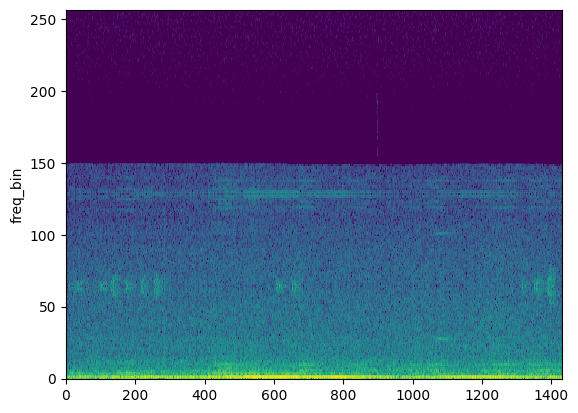

In [18]:
import librosa
import matplotlib.pyplot as plt
from torchaudio.transforms import Spectrogram
spectogram = Spectrogram(n_fft=512)
spec = spectogram(waveform)
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(spec[0])


In [19]:
waveform.to(device=torch.device("cuda"), dtype=torch.float32)

tensor([[-0.0143, -0.0168, -0.0163,  ..., -0.0013, -0.0034, -0.0026],
        [-0.0143, -0.0169, -0.0163,  ..., -0.0013, -0.0034, -0.0027]],
       device='cuda:0')

In [20]:
from torchaudio.transforms import *

class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=8000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = Spectrogram(n_fft=n_fft, power=2)

        self.spec_aug = torch.nn.Sequential(
            TimeStretch(stretch_factor, fixed_rate=True),
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
        )

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)

        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel
    
# Instantiate a pipeline
pipeline = MyPipeline()

# Move the computation graph to CUDA
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)
waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)

# Perform the transform
features = pipeline(waveform)

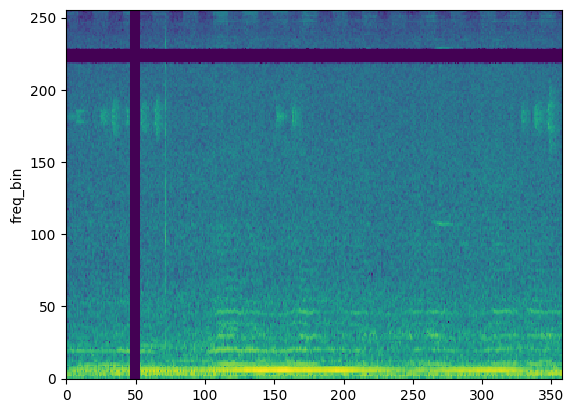

In [21]:
plot_spectrogram(features[0].cpu().numpy()) # features

In [22]:
import pywt
import numpy as np

wavelets = pywt.cwt(waveform[0].numpy(), wavelet="morl", scales=pywt.frequency2scale('morl', np.array([2000, 1500, 1000, 750, 500, 200])/1000), sampling_period=0.001)
fig, ax = plt.subplots(1,1)
im = ax.imshow(wavelets[0], interpolation='nearest', aspect='auto', origin='lower')
plt.colorbar(im)
plt.yticks(np.arange(wavelets[0].shape[0])[::-1],np.round(wavelets[1],3))
plt.xlabel('Inline No.')
plt.ylabel('Wavelet Frequencys')
plt.show()


ModuleNotFoundError: No module named 'pywt'

In [ ]:
pywt.frequency2scale('morl', np.array([1000, 500, 200, 100, 50, 25, 10, 5, 2])/100)

array([ 0.08125,  0.1625 ,  0.40625,  0.8125 ,  1.625  ,  3.25   ,
        8.125  , 16.25   , 40.625  ])

In [23]:
waveform[0].numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [25]:
import torch
from noisereduce.torchgate import TorchGate as TG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tg = TG(sr=8000, nonstationary=True).to(device)

noisy = waveform
clean = tg(noisy)

print(clean)

tensor([[-0.0027, -0.0012, -0.0010,  ..., -0.0049, -0.0037, -0.0027],
        [-0.0026, -0.0013, -0.0010,  ..., -0.0049, -0.0037, -0.0027]],
       device='cuda:0')


# DATE & LOCATION IMPORT

In [2]:
import pandas as pd

inaturalist_bombus_observations = pd.read_csv("observations-386953.csv")

inaturalist_bombus_observations.head()

id observed_on_string observed_on time_observed_at  \
0    6102         2010-03-17  2010-03-17              NaN   
1    6208         2009-03-16  2009-03-16              NaN   
2   61525         2012-04-01  2012-04-01              NaN   
3  111929         2012-06-04  2012-06-04              NaN   
4  188227    August 26, 2012  2012-08-26              NaN   

                    time_zone  user_id user_login         user_name  \
0                         UTC      160     tiggrx               Tig   
1                         UTC      160     tiggrx               Tig   
2                      London     4989    acljohn               NaN   
3               Europe/London     4989    acljohn               NaN   
4  Eastern Time (US & Canada)    11758     jaderr  Rebecca Rissanen   

                  created_at                 updated_at  ... geoprivacy  \
0  2010-03-20 06:46:39 +0000  2023-07-17 03:20:37 +0000  ...        NaN   
1  2010-03-24 19:55:17 +0000  2021-04-09 08:21:21 +0000  ...        NaN   
2  2012-04-01 13:59:16 +0000  2021-04-09 08:21:12 +0000  ...        NaN   
3  2012-08-12 15:01:28 +0000  2019-09-18 09:52:40 +0000  ...        NaN   
4  2013-01-29 15:40:00 +0000  2020-06-09 11:59:58 +0000  ...        NaN   

  taxon_geoprivacy coordinates_obscured positioning_method positioning_device  \
0              NaN                False                NaN                NaN   
1              NaN                False                NaN                NaN   
2              NaN                False                NaN                NaN   
3              NaN                False                NaN                NaN   
4              NaN                False                NaN                NaN   

                species_guess    scientific_name             common_name  \
0  Large Red-tailed Bumblebee  Bombus lapidarius   Red-tailed Bumble Bee   
1       Buff-tailed Bumblebee  Bombus terrestris  Buff-tailed Bumble Bee   
2      Buff-tailed Bumble Bee  Bombus terrestris  Buff-tailed Bumble Bee   
3                 Bumble Bees             Bombus             Bumble Bees   
4      Buff-tailed Bumble Bee  Bombus terrestris  Buff-tailed Bumble Bee   

   iconic_taxon_name  taxon_id  
0            Insecta     57619  
1            Insecta     57516  
2            Insecta     57516  
3            Insecta     52775  
4            Insecta     57516  

[5 rows x 39 columns]

In [3]:
inaturalist_bombus_observations.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [4]:
bombus_df = inaturalist_bombus_observations.copy()

bombus_df = bombus_df[['id', 'latitude', 'longitude', 'scientific_name', 'observed_on']]



In [5]:
print(len(bombus_df['scientific_name'].value_counts()))

25


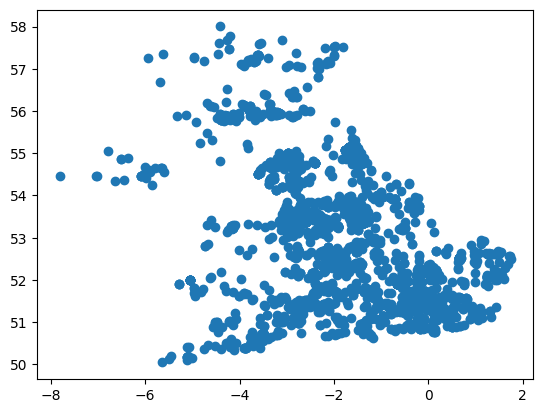

In [6]:
bombus_pratorum = bombus_df[bombus_df['scientific_name'] == 'Bombus pratorum']

import matplotlib.pyplot as plt

plt.scatter(bombus_pratorum['longitude'], bombus_pratorum['latitude'])
plt.show()


# Preprocessing

In [7]:
# limit scope

top = bombus_df['scientific_name'].value_counts()[:10].index
bombus_df = bombus_df[bombus_df['scientific_name'].isin(top)]

In [8]:
# Date encoding
import numpy as np

def cyclic_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


bombus_df['observed_on'] = pd.to_datetime(bombus_df['observed_on'])
bombus_df['observed_on'] = bombus_df['observed_on'].dt.dayofyear

bombus_df = cyclic_encode(bombus_df, 'observed_on', 365)

In [9]:
# Location encoding

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
bombus_df['longitude'] = min_max_scaler.fit_transform(bombus_df[['longitude']])
bombus_df['latitude'] = min_max_scaler.fit_transform(bombus_df[['latitude']])

# scale date

# bombus_df['observed_on_cos'] = min_max_scaler.fit_transform(bombus_df[['observed_on_cos']])
# bombus_df['observed_on_sin'] = min_max_scaler.fit_transform(bombus_df[['observed_on_sin']])

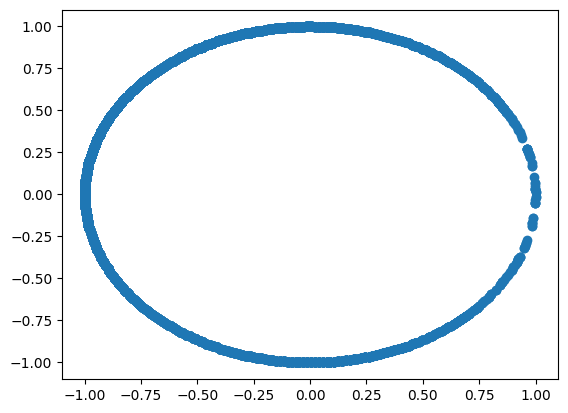

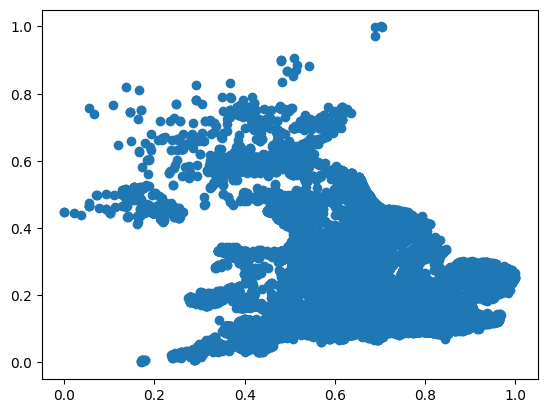

In [10]:
import matplotlib.pyplot as plt

plt.scatter(bombus_df['observed_on_cos'], bombus_df['observed_on_sin'])
plt.show()

plt.scatter(bombus_df['longitude'], bombus_df['latitude'])
plt.show()

In [11]:
bombus_df['observed_on'].min()

1

In [12]:
from sklearn import model_selection

train, test = model_selection.train_test_split(bombus_df, test_size=0.3)

x_train = train[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_train = train[['scientific_name']]
x_test = test[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_test = test[['scientific_name']]

print(y_test.value_counts())

scientific_name        
Bombus pascuorum           2170
Bombus terrestris          1281
Bombus lapidarius          1199
Bombus hypnorum            1157
Bombus pratorum             665
Bombus terrestris audax     179
Bombus hortorum             178
Bombus vestalis             111
Bombus monticola             64
Bombus rupestris             33
Name: count, dtype: int64


In [13]:
import imblearn

ros = imblearn.over_sampling.RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

In [14]:
print(y_train.value_counts())

scientific_name        
Bombus hortorum            4929
Bombus hypnorum            4929
Bombus lapidarius          4929
Bombus monticola           4929
Bombus pascuorum           4929
Bombus pratorum            4929
Bombus rupestris           4929
Bombus terrestris          4929
Bombus terrestris audax    4929
Bombus vestalis            4929
Name: count, dtype: int64


# Method Tests

In [48]:
# KNN

from sklearn import neighbors
import numpy as np
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, np.ravel(y_train))

knn.score(x_test, np.ravel(y_test))

0.2751172374591445

In [49]:
# Logistic Regression

from sklearn import linear_model

lr = linear_model.LogisticRegression(max_iter=1000)
lr.fit(x_train, np.ravel(y_train))

lr.score(x_test, np.ravel(y_test))



0.15716924825920137

In [47]:
# SVM

from sklearn import svm

svm = svm.SVC()
svm.fit(x_train, np.ravel(y_train))

svm.score(x_test, np.ravel(y_test))

0.2059116100611056

In [15]:
# Random Forest

from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(x_train, np.ravel(y_train))

rf.score(x_test, np.ravel(y_test))

0.33664914025863296

In [19]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree0 = rf.estimators_[0]
tree_to_code(tree0, ['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin'])

def tree(longitude, latitude, observed_on_cos, observed_on_sin):
  if latitude <= 0.6170439124107361:
    if observed_on_sin <= -0.012910176534205675:
      if observed_on_sin <= -0.7206604778766632:
        if observed_on_cos <= 0.2678043842315674:
          if observed_on_cos <= 0.1500498354434967:
            if latitude <= 0.45088015496730804:
              if latitude <= 0.18702933937311172:
                if longitude <= 0.8911190927028656:
                  if observed_on_cos <= 0.13300977647304535:
                    if latitude <= 0.1869940236210823:
                      if observed_on_sin <= -0.8840347826480865:
                        if observed_on_sin <= -0.8995975255966187:
                          if observed_on_cos <= -0.2925895005464554:
                            if longitude <= 0.6968185007572174:
                              if observed_on_sin <= -0.9398212432861328:
                                if observed_on_cos <= -0.3090055584907532:
                   

KeyboardInterrupt: 

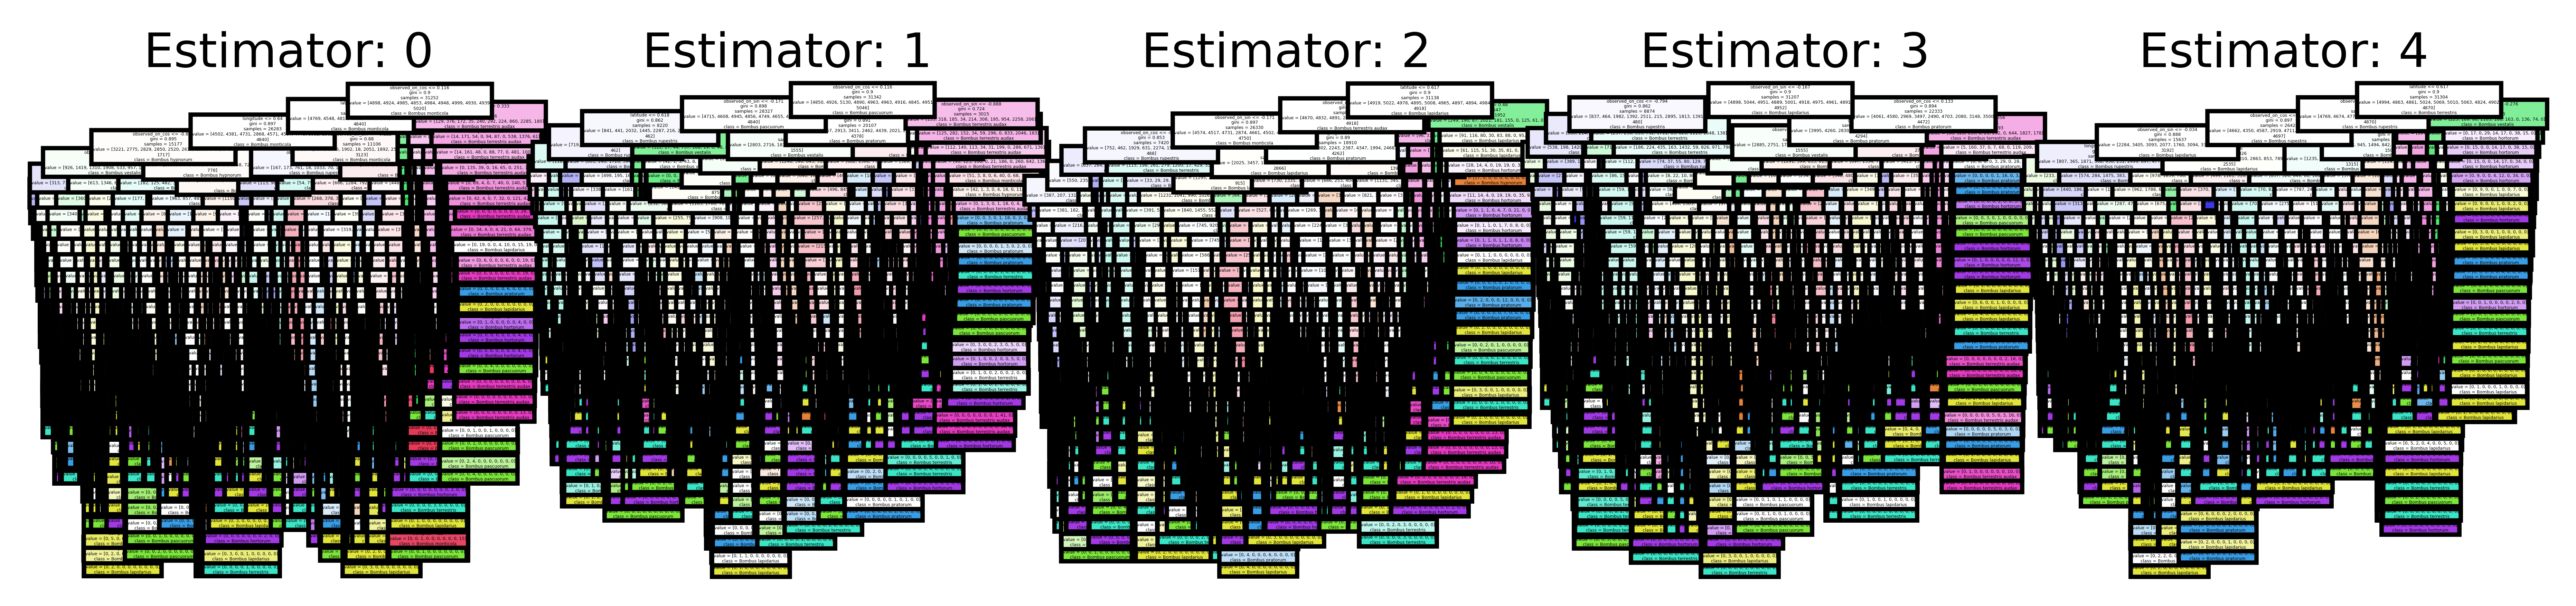

In [57]:
# from sklearn import tree

# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
# for index in range(0, 5):
#     tree.plot_tree(rf.estimators_[index],
#                    feature_names = ['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin'],
#                    class_names=list(y_train['scientific_name'].value_counts().index),
#                    filled = True,
#                    ax = axes[index])

#     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# fig.savefig('rf_5trees.png')

In [44]:
# K Means

from sklearn import cluster, decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(x_train)

km = cluster.KMeans(n_clusters=10)
label = km.fit_predict(pca.transform(x_train))

print(label)
km.score(pca.transform(x_train))



d:\Documents\VSCode Projects\bees\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[9 0 9 ... 2 9 6]


-895.7414389547785

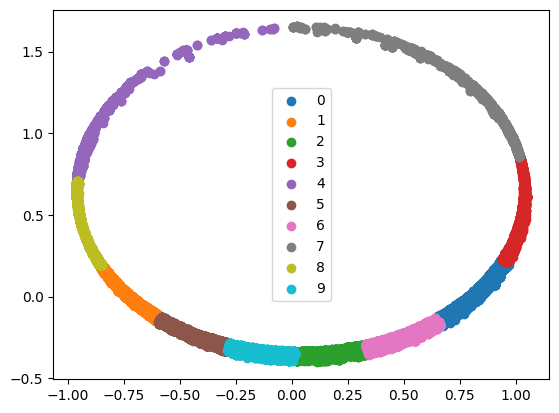

In [45]:
import matplotlib.pyplot as plt
x_train_pca = pca.transform(x_train)
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(x_train_pca[label == i , 0] , x_train_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [61]:
# Calibrated Classifier

# from sklearn import calibration

# cc = calibration.CalibratedClassifierCV(svm)
# cc.fit(x_train, np.ravel(y_train))
# cc.score(x_test, np.ravel(y_test))

In [46]:
# XGBoost

from sklearn import ensemble

gbc = ensemble.HistGradientBoostingClassifier()
gbc.fit(x_train, np.ravel(y_train))

gbc.score(x_test, np.ravel(y_test))

0.32556487139406

In [58]:
# metrics

from sklearn import metrics

class_names = list(y_test['scientific_name'].value_counts().index)

cm = metrics.confusion_matrix(np.ravel(y_test), np.ravel(rf.predict(x_test)), normalize='true')

# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(class_names):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is the ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

['Bombus pascuorum', 'Bombus terrestris', 'Bombus hypnorum', 'Bombus lapidarius', 'Bombus pratorum']
[0.4191666666666667, 0.3115622241835834, 0.4695977549111319, 0.2743988684582744, 0.29698375870069604]


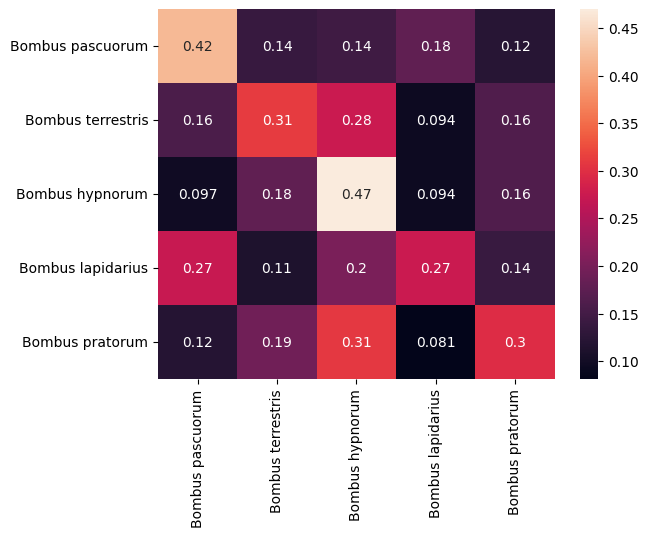

In [59]:
import seaborn as sns

class_names = list(y_test['scientific_name'].value_counts().index)

sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)

corr = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(class_names))]

print(class_names)
print(corr)
    

In [60]:
svm.support_vectors_

array([[ 0.75457294,  0.35894679, -0.79877937,  0.60162406],
       [ 0.58901332,  0.33530818, -0.93228921,  0.36171373],
       [ 0.55446408,  0.15312354, -0.81901489,  0.57377227],
       ...,
       [ 0.48166771,  0.4618731 , -0.63210341, -0.77488404],
       [ 0.95885182,  0.14566793, -0.89774339,  0.44051878],
       [ 0.65938655,  0.47484955, -0.856551  , -0.51606239]])

# Export